In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import os
# !pip install statsmodels

In [6]:
# DF de socios por mes
socios_por_mes_tot = pd.read_pickle(r'C:\Users\emita\Bootcamp\EDA\PICKLES\socios_por_mes_tot.pkl') 

# Divido el df socios_por_mes_tot en dos para que sea mas manejable 
socios_hand_por_mes = socios_por_mes_tot.iloc[:, :2]
socios_vol_por_mes = socios_por_mes_tot.drop(columns='SOCIOS_HAND')

In [7]:
# Resultados de ingresos, egresos, permanencias, totales de alumnos y porcentajes
resultados_h = pd.read_pickle(r'C:\Users\emita\Bootcamp\EDA\PICKLES\resultados_h.pkl')
resultados_v = pd.read_pickle(r'C:\Users\emita\Bootcamp\EDA\PICKLES\resultados_v.pkl')

## Egresos Handball

In [8]:
gastos = r"C:\Users\emita\Bootcamp\EDA\data\Ingresos_Egresos_Hand\Egresos_h.csv"
egresos_2024 = pd.read_csv(gastos, header=4)

In [9]:
egresos_2024 = egresos_2024.drop(columns=['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7',	'Unnamed: 8'])

In [10]:
# Modifico la columna de monto, quitandole el simbolo "$" y ajustando los separadres de decimales
egresos_2024['MONTO'] = egresos_2024['MONTO'].str.replace('$', '').str.replace(',', '')

egresos_2024['MONTO'] = egresos_2024['MONTO'].astype(float) 

In [11]:
from datetime import datetime


def convertir_fecha(fecha):
    # Divide la fecha en día, mes y año
    partes = fecha.split('/')
    
    # Si el mes tiene un solo dígito, añade un "0" al inicio
    if len(partes[1]) == 1:
        partes[1] = '0' + partes[1]
    
    # Si el año tiene dos dígitos, añade "20" al inicio para convertirlo a cuatro dígitos
    if len(partes[2]) == 2:
        partes[2] = '20' + partes[2]
    
    # Une las partes nuevamente en el formato "dd/mm/yyyy"
    fecha_formateada = '/'.join(partes)
    
    # Convierte la fecha al formato "YYYY-MM-DD"
    fecha_convertida = datetime.strptime(fecha_formateada, '%d/%m/%Y').strftime('%Y-%m-%d')
    
    return fecha_convertida

In [12]:
# Aplica la función a cada valor de la columna "FECHA"
egresos_2024['FECHA'] = egresos_2024['FECHA'].apply(convertir_fecha)
egresos_2024['FECHA'] = pd.to_datetime(egresos_2024['FECHA'])

In [13]:
# Compruebo que no haya ningun valor nulo en el df
egresos_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   FECHA        94 non-null     datetime64[ns]
 1   DESCRIPCIÓN  94 non-null     object        
 2   MONTO        94 non-null     float64       
 3   M. DE PAGO   94 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.1+ KB


In [14]:
egresos_2024['DESCRIPCIÓN'].unique()

array(['Gastos Locacion', 'Materiales', 'Salarios', 'Ajuste cuentas',
       'AMPAT', 'Seguro AP', 'Seguro RC', 'Eventos', 'Indumentaria',
       'Federacion'], dtype=object)

In [15]:
egresos_2024.columns=['FECHA', 'DESCRIPCION', 'MONTO', 'MEDIO DE PAGO']

In [16]:
egresos_2024['DESCRIPCION'].unique() 

# Eliminamos los siguientes items, ya que no se consideran gastos propios de la act del dia a dia del club: 'Ajuste cuentas','Eventos', 'Indumentaria','Federacion'
gastos_reales =  ['Gastos Locacion', 'Materiales', 'Salarios', 'AMPAT', 'Seguro AP', 'Seguro RC']
filtro= egresos_2024.loc[:, 'DESCRIPCION'].isin(gastos_reales)
egresos_reales=egresos_2024[filtro]

In [17]:
egresos_reales['DESCRIPCION'] = egresos_reales['DESCRIPCION'].replace({
    'AMPAT': 'Seguro',
    'Seguro AP': 'Seguro',
    'Seguro RC': 'Seguro'}) 
egresos_reales['DESCRIPCION'].unique()

C:\Users\emita\AppData\Local\Temp\ipykernel_55420\2845775864.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  egresos_reales['DESCRIPCION'] = egresos_reales['DESCRIPCION'].replace({


array(['Gastos Locacion', 'Materiales', 'Salarios', 'Seguro'],
      dtype=object)

### Egresos

#### Egresos totales por mes

In [18]:
# Calculo ingresos totales por mes:

egresos_totales_por_mes = egresos_reales.groupby(egresos_reales['FECHA'].dt.to_period('M'))['MONTO'].sum().reset_index()

# Cambiar el formato del periodo a un tipo de fecha
egresos_totales_por_mes['FECHA'] = egresos_totales_por_mes['FECHA'].dt.to_timestamp()

# Renombrar la columna de montos
egresos_totales_por_mes.rename(columns={'MONTO': 'MONTO TOTAL'}, inplace=True)

# Mostrar el DataFrame resultante
egresos_totales_por_mes

,FECHA,MONTO TOTAL
0,2024-02-01,595937.00
1,2024-03-01,654554.00
2,2024-04-01,671780.00
3,2024-05-01,921975.48
4,2024-06-01,1168196.00
5,2024-07-01,1025506.99
6,2024-08-01,1147687.00
7,2024-09-01,1100452.00
8,2024-10-01,1153801.64


#### Egresos totales por mes por categoria

In [19]:
# Agrupar por año y mes, y por categoría, y sumar los montos
eg_totales_por_mes_categoria = egresos_reales.groupby([egresos_reales['FECHA'].dt.to_period('M'), 'DESCRIPCION'])[['MONTO']].sum().reset_index()

# Cambiar el formato del periodo a un tipo de fecha
eg_totales_por_mes_categoria['FECHA'] = eg_totales_por_mes_categoria['FECHA'].dt.to_timestamp()

# Renombrar la columna de montos
eg_totales_por_mes_categoria.rename(columns={'MONTO': 'MONTO TOTAL'}, inplace=True)

# Mostrar el DataFrame resultante
eg_totales_por_mes_categoria

,FECHA,DESCRIPCION,MONTO TOTAL
0,2024-02-01,Gastos Locacion,62000.00
1,2024-02-01,Materiales,223437.00
2,2024-02-01,Salarios,300500.00
3,2024-02-01,Seguro,10000.00
4,2024-03-01,Gastos Locacion,42054.00
5,2024-03-01,Salarios,612500.00
6,2024-04-01,Gastos Locacion,3500.00
7,2024-04-01,Salarios,476500.00
8,2024-04-01,Seguro,191780.00
9,2024-05-01,Salarios,774645.48


#### Egresos totales por categoria

In [20]:
egresos_por_cat = eg_totales_por_mes_categoria.groupby('DESCRIPCION')[['MONTO TOTAL']].sum().reset_index()
egresos_por_cat

,DESCRIPCION,MONTO TOTAL
0,Gastos Locacion,196154.00
1,Materiales,750614.63
2,Salarios,6602145.48
3,Seguro,890976.00


#### Coste del seguro por jugador ------------> ya esta

In [21]:
filtro3= egresos_reales.loc[:, 'DESCRIPCION']== 'Seguro'
mask_pago_seguros=egresos_reales[filtro3]

In [22]:
mask_pago_seguros=mask_pago_seguros.groupby(mask_pago_seguros['FECHA'].dt.to_period('M'))[['MONTO']].sum().reset_index()

In [23]:
# Contamos desde abril hasta octubre, ya que en feb se pago solo 1 seguro, y en marzo nada. 
media_seg_por_mes_h = mask_pago_seguros['MONTO'][1:].mean()

In [24]:
media_soc_por_mes_h = socios_por_mes_tot['SOCIOS_HAND'].mean()

In [25]:
# Coste promedio de los 3 seguros por jugador.
media_seguro_h_jugador = round(media_seg_por_mes_h/media_soc_por_mes_h, 2)

media_seguro_h_jugador

np.float64(1099.39)

#### Coste del salario por jugador

In [26]:
filtro_salarios_h=eg_totales_por_mes_categoria.loc[:, 'DESCRIPCION'] == 'Salarios'
mask_salarios_h = eg_totales_por_mes_categoria[filtro_salarios_h]
salarios_por_mes_h = mask_salarios_h.reset_index(drop=True)

In [27]:
salarios_por_mes_h

,FECHA,DESCRIPCION,MONTO TOTAL
0,2024-02-01,Salarios,300500.00
1,2024-03-01,Salarios,612500.00
2,2024-04-01,Salarios,476500.00
3,2024-05-01,Salarios,774645.48
4,2024-06-01,Salarios,697000.00
5,2024-07-01,Salarios,825000.00
6,2024-08-01,Salarios,946000.00
7,2024-09-01,Salarios,885000.00
8,2024-10-01,Salarios,1085000.00


In [28]:
coste_salario_mes_por_jug_h = round(salarios_por_mes_h['MONTO TOTAL']/socios_por_mes_tot['SOCIOS_HAND'], 2)
coste_salario_mes_por_jug_h.mean()

np.float64(5380.391111111112)

## Ingresos Handball

In [29]:
ingresos = r"C:\Users\emita\Bootcamp\EDA\data\Ingresos_Egresos_Hand\Ingresos_h.csv"
ingresos_2024 = pd.read_csv(ingresos, header=0)

Tener en cuenta:
Valor de las cuotas:
- $ 7200 de febrero a abril
- $ 8700 de mayo a agosto
- $ 11500 de septiembre en adelante 

In [30]:
# Calculo el porcentaje de aumento de las cuotas, para tenerlo en cuenta luego: 
valor_1 = 7200 # de febrero a abril
valor_2 = 8700 # de mayo a agosto
valor_3 = 11500 # de septiembre en adelante 
primer_aumento = round(((valor_2 - valor_1)/valor_1) * 100,2)
print("Primer aumento: ", primer_aumento)

segundo_aumento = round(((valor_3 - valor_2)/valor_2) * 100,2)
print("Segundo aumento: ", segundo_aumento)

Primer aumento:  20.83
Segundo aumento:  32.18


In [31]:
ingresos_2024=ingresos_2024.drop(columns=['MES', 'Unnamed: 6', 'Unnamed: 7', 'INGRESOS HANDBALL 2024','Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11','Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14','Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17','Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',])
ingresos_2024=ingresos_2024.iloc[:1063,:]

In [32]:
ingresos_2024.columns

Index(['FECHA', 'DESCRIPCIÓN', 'MONTO', 'CATEGORIA', 'M. DE PAGO'], dtype='object')

In [33]:
ingresos_2024.columns=['FECHA', 'DESCRIPCION', 'MONTO', 'CATEGORIA','MEDIO DE PAGO']

In [34]:
ingresos_2024

,FECHA,DESCRIPCION,MONTO,CATEGORIA,MEDIO DE PAGO
0,5/2/2024,Cuota,"$7,200.00",Menores,Tranferencia
1,5/2/2024,Cuota,"$7,200.00",Menores,Tranferencia
2,5/2/2024,Cuota,"$7,200.00",Cadetes,Tranferencia
3,5/2/2024,Cuota,"$6,120.00",Cadetes,Tranferencia
4,5/2/2024,Cuota,"$6,120.00",Cadetes,Tranferencia
...,...,...,...,...,...
1058,28/9/2024,Cuota,"$11,475.00",Mini,Transferencia
1059,28/9/2024,Cuota,"$11,475.00",Infantil,Transferencia
1060,3/10/2024,Cuota adeudada,"$19,200.00",Cadetes,Transferencia
1061,14/10/2024,Cuota,"$13,500.00",Menores,Transferencia


In [35]:
ingresos_2024.columns

Index(['FECHA', 'DESCRIPCION', 'MONTO', 'CATEGORIA', 'MEDIO DE PAGO'], dtype='object')

In [36]:
ingresos_2024['MONTO'] = ingresos_2024['MONTO'].str.replace('$', '').str.replace(',', '')

ingresos_2024['MONTO'] = ingresos_2024['MONTO'].astype(float)

In [37]:
# Aplica la función a cada valor de la columna "FECHA"
ingresos_2024['FECHA'] = ingresos_2024['FECHA'].apply(convertir_fecha)
ingresos_2024['FECHA'] = pd.to_datetime(ingresos_2024['FECHA'])

In [38]:
ingresos_2024['CATEGORIA'].unique()

array(['Menores', 'Cadetes', 'Infantil', 'Mayores', 'Cadete', 'Juvenil',
       'Mini', 'Cadeta', 'Menor', 'No procede', 'Mayor', 'MINI',
       'Administracion', 'MIni', 'Cadetas', 'Sponsor', 'Ajuste',
       'menores', 'juvenil', 'infantil', 'Envio', 'Indumentaria',
       'cadetes', 'Juveniles', 'Infantiles', '???'], dtype=object)

In [39]:
ingresos_2024['CATEGORIA']=ingresos_2024['CATEGORIA'].replace(["Cadete","Cadeta",'cadetes',"Cadetas"], "Cadetes")
ingresos_2024['CATEGORIA']=ingresos_2024['CATEGORIA'].replace(['Menor', 'menor', 'menores'], "Menores")
ingresos_2024['CATEGORIA']=ingresos_2024['CATEGORIA'].replace(["Infantil",'infantil'], "Infantiles")
ingresos_2024['CATEGORIA']=ingresos_2024['CATEGORIA'].replace(["MINI",'MIni', '???'], "Mini")
ingresos_2024['CATEGORIA']=ingresos_2024['CATEGORIA'].replace("Mayor", "Mayores")
ingresos_2024['CATEGORIA']=ingresos_2024['CATEGORIA'].replace(["Juvenil",'juvenil'], "Juveniles")
ingresos_2024['CATEGORIA']=ingresos_2024['CATEGORIA'].replace('primera', "Primera")
ingresos_2024['CATEGORIA']=ingresos_2024['CATEGORIA'].replace(['Administracion', 'Sponsor', 'Ajuste', 'Envio','Indumentaria'], "No procede")

In [40]:
ingresos_2024['CATEGORIA']=ingresos_2024['CATEGORIA'].replace(["Tranferencia", 'Tranferencia '], "Transferencia")

In [41]:
ingresos_2024['DESCRIPCION'].unique()

array(['Cuota', 'Cambio divisas ahorros', 'Cuota adeudada', 'Locacion',
       'SPONSOR CASINO VIRTUAL', 'Cuota medio mes', 'Ingreso erroneo',
       'Indumentaria institucional', 'Seguro', 'Sponsor Perramon',
       'Administracion', 'Eventos'], dtype=object)

In [42]:
ingresos_2024.columns=['FECHA', 'DESCRIPCION', 'MONTO', 'CATEGORIA', 'MEDIO DE PAGO']

In [43]:
ingresos_2024['CATEGORIA'] = ingresos_2024.loc[:, 'CATEGORIA'].str.capitalize()

In [44]:
# Nos aseguramos que no haya ningun Null
ingresos_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   FECHA          1063 non-null   datetime64[ns]
 1   DESCRIPCION    1063 non-null   object        
 2   MONTO          1063 non-null   float64       
 3   CATEGORIA      1063 non-null   object        
 4   MEDIO DE PAGO  1063 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 41.6+ KB


In [45]:
ingresos_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   FECHA          1063 non-null   datetime64[ns]
 1   DESCRIPCION    1063 non-null   object        
 2   MONTO          1063 non-null   float64       
 3   CATEGORIA      1063 non-null   object        
 4   MEDIO DE PAGO  1063 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 41.6+ KB


In [46]:
ingresos_2024['DESCRIPCION'].unique()

array(['Cuota', 'Cambio divisas ahorros', 'Cuota adeudada', 'Locacion',
       'SPONSOR CASINO VIRTUAL', 'Cuota medio mes', 'Ingreso erroneo',
       'Indumentaria institucional', 'Seguro', 'Sponsor Perramon',
       'Administracion', 'Eventos'], dtype=object)

In [47]:
ingresos_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   FECHA          1063 non-null   datetime64[ns]
 1   DESCRIPCION    1063 non-null   object        
 2   MONTO          1063 non-null   float64       
 3   CATEGORIA      1063 non-null   object        
 4   MEDIO DE PAGO  1063 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 41.6+ KB


In [48]:
lista_ingresos_reales = ['Cuota', 'Cambio divisas ahorros', 'Cuota adeudada', 'SPONSOR CASINO VIRTUAL', 'Cuota medio mes', 'Sponsor Perramon', 'Eventos']
ingresos_reales = ingresos_2024[ingresos_2024.loc[:, 'DESCRIPCION'].isin(lista_ingresos_reales)]
ingresos_reales=ingresos_reales.reset_index(drop=True)
ingresos_reales

,FECHA,DESCRIPCION,MONTO,CATEGORIA,MEDIO DE PAGO
0,2024-02-05,Cuota,7200.0,Menores,Tranferencia
1,2024-02-05,Cuota,7200.0,Menores,Tranferencia
2,2024-02-05,Cuota,7200.0,Cadetes,Tranferencia
3,2024-02-05,Cuota,6120.0,Cadetes,Tranferencia
4,2024-02-05,Cuota,6120.0,Cadetes,Tranferencia
...,...,...,...,...,...
1027,2024-09-28,Cuota,11475.0,Mini,Transferencia
1028,2024-09-28,Cuota,11475.0,Infantiles,Transferencia
1029,2024-10-03,Cuota adeudada,19200.0,Cadetes,Transferencia
1030,2024-10-14,Cuota,13500.0,Menores,Transferencia


### Ingresos por categoria

In [49]:
# Filtro cuales de los ingresos son pago de cuota de socios
ingresos_cuotas =  ['Cuota', 'Cuota adeudada', 'Cuota medio mes']

pago_cuotas = ingresos_reales[ingresos_reales.loc[:, 'DESCRIPCION'].isin(ingresos_cuotas)]
ingresos_por_cuotas_hand = pago_cuotas.groupby('CATEGORIA')[['MONTO']].sum().reset_index()
ingresos_por_cuotas_hand=ingresos_por_cuotas_hand.sort_values(by='MONTO', ascending=False)
ingresos_por_cuotas_hand

,CATEGORIA,MONTO
3,Mayores,2392880.00
4,Menores,2041597.83
0,Cadetes,1327665.67
5,Mini,1272846.16
1,Infantiles,1117127.33
2,Juveniles,802160.00


<Figure size 1000x600 with 0 Axes>

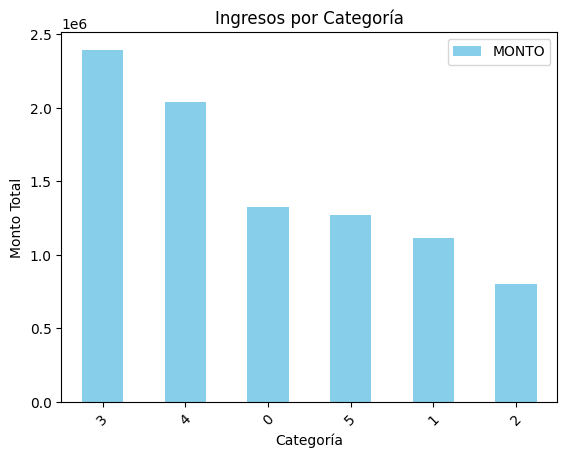

In [50]:
# Graficar los ingresos por categoría
plt.figure(figsize=(10, 6))
ingresos_por_cuotas_hand.plot(kind='bar', color='skyblue')
plt.title('Ingresos por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Monto Total')
plt.xticks(rotation=45)
plt.show()

#### Ingresos totales por mes

In [51]:
ingresos_reales['DESCRIPCION'].unique()

array(['Cuota', 'Cambio divisas ahorros', 'Cuota adeudada',
       'SPONSOR CASINO VIRTUAL', 'Cuota medio mes', 'Sponsor Perramon',
       'Eventos'], dtype=object)

In [52]:
# Calcular ingresos totales por mes
ingresos_totales_por_mes = ingresos_reales.groupby(ingresos_reales['FECHA'].dt.to_period('M'))['MONTO'].sum().reset_index()

# Cambiar el formato del periodo a un tipo de fecha
ingresos_totales_por_mes['FECHA'] = ingresos_totales_por_mes['FECHA'].dt.to_timestamp()

# Renombrar la columna de montos
ingresos_totales_por_mes.rename(columns={'MONTO': 'MONTO TOTAL'}, inplace=True)
ingresos_totales_por_mes

,FECHA,MONTO TOTAL
0,2024-02-01,583660.00
1,2024-03-01,749510.00
2,2024-04-01,824019.98
3,2024-05-01,970029.00
4,2024-06-01,1113898.00
5,2024-07-01,1087640.00
6,2024-08-01,1178750.00
7,2024-09-01,1393384.99
8,2024-10-01,1442885.02


In [53]:
combinados = pd.merge(ingresos_totales_por_mes, socios_hand_por_mes, left_index=True, right_index=True)
combinados= combinados.drop(columns='MES')
combinados

,FECHA,MONTO TOTAL,SOCIOS_HAND
0,2024-02-01,583660.00,77
1,2024-03-01,749510.00,122
2,2024-04-01,824019.98,135
3,2024-05-01,970029.00,138
4,2024-06-01,1113898.00,145
5,2024-07-01,1087640.00,131
6,2024-08-01,1178750.00,148
7,2024-09-01,1393384.99,151
8,2024-10-01,1442885.02,155


#### Ingresos por mes por categoria

In [54]:
# Agrupar por año y mes, y por categoría, y sumar los montos
df_totales_por_mes_categoria = ingresos_reales.groupby([ingresos_reales['FECHA'].dt.to_period('M'), 'CATEGORIA'])[['MONTO']].sum().reset_index()

# Cambiar el formato del periodo a un tipo de fecha
df_totales_por_mes_categoria['FECHA'] = df_totales_por_mes_categoria['FECHA'].dt.to_timestamp()

# Renombrar la columna de montos
df_totales_por_mes_categoria.rename(columns={'MONTO': 'MONTO TOTAL'}, inplace=True)

# Mostrar el DataFrame resultante
df_totales_por_mes_categoria

,FECHA,CATEGORIA,MONTO TOTAL
0,2024-02-01,Cadetes,103320.00
1,2024-02-01,Infantiles,54450.00
2,2024-02-01,Juveniles,54620.00
3,2024-02-01,Mayores,121860.00
4,2024-02-01,Menores,94400.00
5,2024-02-01,Mini,35010.00
6,2024-02-01,No procede,120000.00
7,2024-03-01,Cadetes,109160.00
8,2024-03-01,Infantiles,83190.00
9,2024-03-01,Juveniles,52920.00


In [55]:
fig = px.bar(df_totales_por_mes_categoria, x='FECHA', y='MONTO TOTAL', color='CATEGORIA', 
             barmode='group',
             title='Comparativa Mensual de Ingresos por Categoría',
             labels={'MONTO': 'Monto Total', 'FECHA': 'Fecha'})

fig.update_layout(
    xaxis_title="Fecha",
    yaxis_title="Monto Total",
    plot_bgcolor='white',
    hovermode='x unified'
)

fig.show()

#### Ingresos totales por categoria
Contando solo los ingresos de las cuotas

In [56]:
tot_por_cat_h = df_totales_por_mes_categoria.groupby('CATEGORIA')[['MONTO TOTAL']].sum().reset_index().sort_values(by='MONTO TOTAL', ascending=False)
tot_por_cat_h

,CATEGORIA,MONTO TOTAL
3,Mayores,2392880.00
4,Menores,2041597.83
0,Cadetes,1327665.67
5,Mini,1272846.16
1,Infantiles,1117127.33
2,Juveniles,802160.00
6,No procede,389500.00


### Ingresos vs egresos

In [57]:
ingresos_egresos_h = pd.merge(ingresos_totales_por_mes, egresos_totales_por_mes, on='FECHA')
ingresos_egresos_h.columns=['FECHA', 'INGRESOS', 'EGRESOS']
ingresos_egresos_h

,FECHA,INGRESOS,EGRESOS
0,2024-02-01,583660.00,595937.00
1,2024-03-01,749510.00,654554.00
2,2024-04-01,824019.98,671780.00
3,2024-05-01,970029.00,921975.48
4,2024-06-01,1113898.00,1168196.00
5,2024-07-01,1087640.00,1025506.99
6,2024-08-01,1178750.00,1147687.00
7,2024-09-01,1393384.99,1100452.00
8,2024-10-01,1442885.02,1153801.64


In [58]:
ingresos_egresos_h['SALDO'] = ingresos_egresos_h['INGRESOS'] - ingresos_egresos_h['EGRESOS']
ingresos_egresos_h['FECHA'] = ['FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEPT', 'OCT']
ingresos_egresos_h

,FECHA,INGRESOS,EGRESOS,SALDO
0,FEB,583660.00,595937.00,-12277.00
1,MAR,749510.00,654554.00,94956.00
2,ABR,824019.98,671780.00,152239.98
3,MAY,970029.00,921975.48,48053.52
4,JUN,1113898.00,1168196.00,-54298.00
5,JUL,1087640.00,1025506.99,62133.01
6,AGO,1178750.00,1147687.00,31063.00
7,SEPT,1393384.99,1100452.00,292932.99
8,OCT,1442885.02,1153801.64,289083.38


In [59]:
ingresos_egresos_h['INGRESOS POR SOCIO'] = round(ingresos_egresos_h['INGRESOS']/socios_por_mes_tot['SOCIOS_HAND'], 2)
ingresos_egresos_h['EGRESOS POR SOCIO'] = round(ingresos_egresos_h['EGRESOS']/socios_por_mes_tot['SOCIOS_HAND'], 2)
ingresos_egresos_h['SALDO POR SOCIO'] = round(ingresos_egresos_h['SALDO']/socios_por_mes_tot['SOCIOS_HAND'], 2)
ingresos_egresos_h

,FECHA,INGRESOS,EGRESOS,SALDO,INGRESOS POR SOCIO,EGRESOS POR SOCIO,SALDO POR SOCIO
0,FEB,583660.00,595937.00,-12277.00,7580.00,7739.44,-159.44
1,MAR,749510.00,654554.00,94956.00,6143.52,5365.20,778.33
2,ABR,824019.98,671780.00,152239.98,6103.85,4976.15,1127.70
3,MAY,970029.00,921975.48,48053.52,7029.20,6680.98,348.21
4,JUN,1113898.00,1168196.00,-54298.00,7682.06,8056.52,-374.47
5,JUL,1087640.00,1025506.99,62133.01,8302.60,7828.30,474.30
6,AGO,1178750.00,1147687.00,31063.00,7964.53,7754.64,209.89
7,SEPT,1393384.99,1100452.00,292932.99,9227.72,7287.76,1939.95
8,OCT,1442885.02,1153801.64,289083.38,9308.94,7443.88,1865.05


#### Ingresos-egresos por mes por socio y saldo

In [60]:
ingresos_egresos_h['INGRESOS POR SOCIO'] = round(ingresos_egresos_h['INGRESOS']/socios_por_mes_tot['SOCIOS_HAND'], 2)
ingresos_egresos_h['EGRESOS POR SOCIO'] = round(ingresos_egresos_h['EGRESOS']/socios_por_mes_tot['SOCIOS_HAND'], 2)
ingresos_egresos_h['SALDO POR SOCIO'] = round(ingresos_egresos_h['SALDO']/socios_por_mes_tot['SOCIOS_HAND'], 2)
ingresos_egresos_h

,FECHA,INGRESOS,EGRESOS,SALDO,INGRESOS POR SOCIO,EGRESOS POR SOCIO,SALDO POR SOCIO
0,FEB,583660.00,595937.00,-12277.00,7580.00,7739.44,-159.44
1,MAR,749510.00,654554.00,94956.00,6143.52,5365.20,778.33
2,ABR,824019.98,671780.00,152239.98,6103.85,4976.15,1127.70
3,MAY,970029.00,921975.48,48053.52,7029.20,6680.98,348.21
4,JUN,1113898.00,1168196.00,-54298.00,7682.06,8056.52,-374.47
5,JUL,1087640.00,1025506.99,62133.01,8302.60,7828.30,474.30
6,AGO,1178750.00,1147687.00,31063.00,7964.53,7754.64,209.89
7,SEPT,1393384.99,1100452.00,292932.99,9227.72,7287.76,1939.95
8,OCT,1442885.02,1153801.64,289083.38,9308.94,7443.88,1865.05


In [61]:
saldo_anual_h = round(ingresos_egresos_h['SALDO'].sum(), 2)
print("El saldo anual total es de:", saldo_anual_h)
saldo_por_socio_f = round(ingresos_egresos_h['SALDO POR SOCIO'].sum(), 2)
print("El saldo anual por socio es de:", saldo_por_socio_f)

El saldo anual total es de: 903886.88
El saldo anual por socio es de: 6209.52


Conclusion: 

En los meses de febrero y junio hubo saldo negativo muy bajo: de $ 119.19 y $ 402.21 respectivamente.

- El saldo anual total es de: 911386.88

- El saldo anual por socio es de: 6597.67

#### Ingresos, egresos y permanencias socios por categoria

In [62]:
resultados_h['CATEGORIA'].unique()

array(['Mini', 'Infantil', 'Menores', 'Cadetes', 'Juveniles', 'Primera'],
      dtype=object)

## Lista becados

In [63]:
becados = r"C:\Users\emita\Bootcamp\EDA\data\Ingresos_Egresos_Hand\Lista_becados.csv"
becas = pd.read_csv(becados)

In [64]:
becas

,NOMBRE,APELLIDO,DISCIPLINA,CATEGORIA,PORCENTAJE BECA,Motivo,Unnamed: 6,Unnamed: 7
0,P,V,Handball,Mayores masculino,100%,Mantenimiento club,NaN,NaN
1,N,A,Handball,Cadetes femenino,100%,Incentivo viaje,NaN,NaN
2,L,A,Handball,Cadetes femenino,50%,Incentivo viaje,NaN,NaN
3,R,R,Handball,Cadetes femenino,50%,Incentivo viaje,NaN,NaN
4,Ma,B,Handball,Cadetes femenino,50%,Incentivo viaje,NaN,NaN
5,C,C,Handball,Cadetes femenino,100%,Incentivo viaje,NaN,NaN
6,F,B,Handball,Mayores femenino,100%,Administracion club,,NaN
7,M,C,Voley,PRIMERA FEMENINO,100%,Motivos economicos,NaN,NaN
8,M,P,Voley,PRIMERA FEMENINO,100%,Profesor club,NaN,NaN
9,I,A,Voley,PRIMERA FEMENINO,100%,Motivos economicos,NaN,NaN


In [65]:
becas=becas.drop(columns=['Unnamed: 6','Unnamed: 7'])
becas.columns=['NOMBRE', 'APELLIDO', 'DISCIPLINA', 'CATEGORIA', 'PORCENTAJE BECA','MOTIVO']

In [66]:
becas['DISCIPLINA'] = becas.loc[:, 'DISCIPLINA'].str.capitalize()

In [67]:
becas['CATEGORIA'] = becas.loc[:, 'CATEGORIA'].str.capitalize()

In [68]:
becas.sort_values(by="APELLIDO").reset_index(drop=True)

,NOMBRE,APELLIDO,DISCIPLINA,CATEGORIA,PORCENTAJE BECA,MOTIVO
0,I,A,Voley,Primera femenino,100%,Motivos economicos
1,N,A,Handball,Cadetes femenino,100%,Incentivo viaje
2,L,A,Handball,Cadetes femenino,50%,Incentivo viaje
3,D,A,Handball,Mayores femenino,100%,Profesor club
4,A,B,Voley,Primera masculino,100%,Profesor club
5,S,B,Handball,Mayores masculino,100%,Profesor club
6,S,B,Voley,Primera femenino,50%,Motivos economicos
7,N,B,Voley,Sub 16 masc,100%,Motivos economicos
8,F,B,Handball,Mayores femenino,100%,Administracion club
9,Ma,B,Handball,Cadetes femenino,50%,Incentivo viaje


In [69]:
# Nos aseguramos que no haya ningun Null
becas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   NOMBRE           31 non-null     object
 1   APELLIDO         31 non-null     object
 2   DISCIPLINA       31 non-null     object
 3   CATEGORIA        31 non-null     object
 4   PORCENTAJE BECA  31 non-null     object
 5   MOTIVO           31 non-null     object
dtypes: object(6)
memory usage: 1.6+ KB


In [70]:
becas

,NOMBRE,APELLIDO,DISCIPLINA,CATEGORIA,PORCENTAJE BECA,MOTIVO
0,P,V,Handball,Mayores masculino,100%,Mantenimiento club
1,N,A,Handball,Cadetes femenino,100%,Incentivo viaje
2,L,A,Handball,Cadetes femenino,50%,Incentivo viaje
3,R,R,Handball,Cadetes femenino,50%,Incentivo viaje
4,Ma,B,Handball,Cadetes femenino,50%,Incentivo viaje
5,C,C,Handball,Cadetes femenino,100%,Incentivo viaje
6,F,B,Handball,Mayores femenino,100%,Administracion club
7,M,C,Voley,Primera femenino,100%,Motivos economicos
8,M,P,Voley,Primera femenino,100%,Profesor club
9,I,A,Voley,Primera femenino,100%,Motivos economicos


In [71]:
# Los motivos de las becas son principalmente: 
# si es trabajador del club: Profesor club, Administracion club, Mantenimiento club
# u otro: Incentivo viaje, Merito deportivo, Motivos economicos
# haremos el analisis sobre estos ultimos 3, ya que los otros motivos son por prestar servicios al club que, de no estar becados, deberian ser pagados un monto mayor. 

motivo_becas = ['Incentivo viaje', 'Merito deportivo', 'Motivos economicos']
filtro= becas['MOTIVO'].isin(motivo_becas)
real_becados = becas[filtro].reset_index(drop=True)
beca_gb = real_becados.groupby('PORCENTAJE BECA')[['DISCIPLINA']].value_counts().reset_index()
beca_gb['PORCENTAJE BECA']= [1, 1, 0.5, 0.5]
beca_gb

,PORCENTAJE BECA,DISCIPLINA,count
0,1.0,Handball,3
1,1.0,Voley,3
2,0.5,Handball,6
3,0.5,Voley,4


In [72]:
beca_voley = real_becados['DISCIPLINA']=='Voley'
becados_voley = real_becados[beca_voley].reset_index(drop=True).drop(columns='DISCIPLINA')
becados_voley

,NOMBRE,APELLIDO,CATEGORIA,PORCENTAJE BECA,MOTIVO
0,M,C,Primera femenino,100%,Motivos economicos
1,I,A,Primera femenino,100%,Motivos economicos
2,S,B,Primera femenino,50%,Motivos economicos
3,B,M,Sub 16 masculino,50%,Motivos economicos
4,J,G,Sub 16 masculino,50%,Motivos economicos
5,MA,F,Sub 18 femenino,50%,Motivos economicos
6,N,B,Sub 16 masc,100%,Motivos economicos


In [73]:
beca_hand = real_becados['DISCIPLINA']=='Handball'
becados_hand = real_becados[beca_hand].reset_index(drop=True).drop(columns='DISCIPLINA')
becados_hand

,NOMBRE,APELLIDO,CATEGORIA,PORCENTAJE BECA,MOTIVO
0,N,A,Cadetes femenino,100%,Incentivo viaje
1,L,A,Cadetes femenino,50%,Incentivo viaje
2,R,R,Cadetes femenino,50%,Incentivo viaje
3,Ma,B,Cadetes femenino,50%,Incentivo viaje
4,C,C,Cadetes femenino,100%,Incentivo viaje
5,L,M,Juveniles damas,50%,Incentivo viaje
6,V,M,Mayores femenino,50%,Incentivo viaje
7,A,JP,Menor masc,50%,Motivos economicos
8,O,P,Cadetes masculino,100%,Merito deportivo


In [74]:
# En total hay 16 becados, haremos el calculo de cuanto dinero representa al club no cobrar la cuota a estos becados:

# Valor de la cuota
valor_cuota = 13500

# Calcular el costo total por alumno becado
beca_gb['COSTO BECA'] = beca_gb['count'] * valor_cuota * beca_gb['PORCENTAJE BECA']

# Calcular el costo total de becas por disciplina
costo_total_becas = beca_gb.groupby('DISCIPLINA')['COSTO BECA'].sum().reset_index()

## Egresos Voley

In [75]:
gastos_v = r"C:\Users\emita\Bootcamp\EDA\data\Ingresos_Egr_Voley\EGRESOS_V.csv"
egresos_v = pd.read_csv(gastos_v, header=4)

In [76]:
egresos_v = egresos_v.iloc[:85, :4]

In [77]:
egresos_v.columns

Index(['FECHA', 'DESCRIPCION', 'MONTO', 'M. DE PAGO'], dtype='object')

In [78]:
# Modifico la columna de monto, quitandole el simbolo "$" y ajustando los separadres de decimales
egresos_v['MONTO'] = egresos_v['MONTO'].str.replace('$', '').str.replace(',', '')

egresos_v['MONTO'] = egresos_v['MONTO'].astype(float) 

In [79]:
# Aplicamos funcion de conevrtir tipo de fecha
egresos_v['FECHA'] = egresos_v['FECHA'].apply(convertir_fecha)
egresos_v['FECHA'] = pd.to_datetime(egresos_v['FECHA'])

In [80]:
# Nos aseguramos que no haya ningun Null
egresos_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   FECHA        85 non-null     datetime64[ns]
 1   DESCRIPCION  85 non-null     object        
 2   MONTO        85 non-null     float64       
 3   M. DE PAGO   85 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.8+ KB


In [81]:
egresos_v.columns=['FECHA', 'DESCRIPCION', 'MONTO', 'MEDIO DE PAGO']

In [82]:
egresos_v['DESCRIPCION'] = egresos_v['DESCRIPCION'].replace({
    'AMPAT': 'Seguro',
    'Seguro AP': 'Seguro',
    'Seguro RC': 'Seguro'}) 
egresos_v['DESCRIPCION'].unique()

array(['Gastos Locacion', 'Salarios', 'Seguro', 'Materiales',
       'Devolucion prestamo'], dtype=object)

In [83]:
# Eliminamos el siguiente items, ya que no se considera gasto propios de la act del dia a dia del club: 'Devolucion prestamo' ()
gastos_reales_v =  ['Gastos Locacion', 'Salarios', 'Seguro', 'Materiales']
filtro_v= egresos_v.loc[:, 'DESCRIPCION'].isin(gastos_reales_v)
egresos_reales_v=egresos_v[filtro_v]

In [84]:
egresos_reales_v['DESCRIPCION'].unique()

array(['Gastos Locacion', 'Salarios', 'Seguro', 'Materiales'],
      dtype=object)

### Egresos totales por mes

In [85]:
# Agrupar por año y mes, y por categoría, y sumar los montos
eg_totales_por_mes = egresos_v.groupby(egresos_v['FECHA'].dt.to_period('M'))[['MONTO']].sum().reset_index()

# Cambiar el formato del periodo a un tipo de fecha
eg_totales_por_mes['FECHA'] = eg_totales_por_mes['FECHA'].dt.to_timestamp()

# Renombrar la columna de montos
eg_totales_por_mes.rename(columns={'MONTO': 'MONTO TOTAL'}, inplace=True)

# Mostrar el DataFrame resultante
eg_totales_por_mes

,FECHA,MONTO TOTAL
0,2024-02-01,538700.0
1,2024-03-01,658900.0
2,2024-04-01,816070.0
3,2024-05-01,845340.0
4,2024-06-01,804700.0
5,2024-07-01,441097.0
6,2024-08-01,1131217.0
7,2024-09-01,833882.0
8,2024-10-01,1182500.0


#### Gastos por mes por categoria

In [86]:
# Agrupar por año y mes, y por categoría, y sumar los montos
eg_totales_por_mes_categoria_v = egresos_v.groupby([egresos_v['FECHA'].dt.to_period('M'), 'DESCRIPCION'])[['MONTO']].sum().reset_index()

# Cambiar el formato del periodo a un tipo de fecha
eg_totales_por_mes_categoria_v['FECHA'] = eg_totales_por_mes_categoria_v['FECHA'].dt.to_timestamp()

# Renombrar la columna de montos
eg_totales_por_mes_categoria_v.rename(columns={'MONTO': 'MONTO TOTAL'}, inplace=True)

# Mostrar el DataFrame resultante
eg_totales_por_mes_categoria_v

,FECHA,DESCRIPCION,MONTO TOTAL
0,2024-02-01,Gastos Locacion,79200.0
1,2024-02-01,Materiales,34000.0
2,2024-02-01,Salarios,415500.0
3,2024-02-01,Seguro,10000.0
4,2024-03-01,Gastos Locacion,66500.0
5,2024-03-01,Materiales,63400.0
6,2024-03-01,Salarios,529000.0
7,2024-04-01,Gastos Locacion,136200.0
8,2024-04-01,Salarios,560000.0
9,2024-04-01,Seguro,119870.0


#### Gastos por categoria

In [87]:
egresos_por_cat_v = eg_totales_por_mes_categoria_v.groupby('DESCRIPCION')[['MONTO TOTAL']].sum().reset_index()
egresos_por_cat_v

,DESCRIPCION,MONTO TOTAL
0,Devolucion prestamo,84000.0
1,Gastos Locacion,651400.0
2,Materiales,123400.0
3,Salarios,5785000.0
4,Seguro,608606.0


#### Coste del seguro por jugador

In [88]:
eg_totales_por_mes_categoria_v['DESCRIPCION'].unique()

filtro4 = eg_totales_por_mes_categoria_v.loc[:, 'DESCRIPCION'] == 'Seguro'
mask_seguros = eg_totales_por_mes_categoria_v[filtro4].reset_index(drop=True)
mask_seguros

,FECHA,DESCRIPCION,MONTO TOTAL
0,2024-02-01,Seguro,10000.0
1,2024-04-01,Seguro,119870.0
2,2024-05-01,Seguro,100340.0
3,2024-06-01,Seguro,88700.0
4,2024-07-01,Seguro,91097.0
5,2024-08-01,Seguro,89717.0
6,2024-09-01,Seguro,108882.0


In [89]:
mask_seguros=mask_seguros.groupby(mask_seguros['FECHA'].dt.to_period('M'))[['MONTO TOTAL']].sum().reset_index()
mask_seguros

,FECHA,MONTO TOTAL
0,2024-02,10000.0
1,2024-04,119870.0
2,2024-05,100340.0
3,2024-06,88700.0
4,2024-07,91097.0
5,2024-08,89717.0
6,2024-09,108882.0


In [90]:
# Contamos desde abril hasta octubre, ya que en feb se pago solo 1 seguro, y en marzo nada. 
media_seg_por_mes = mask_seguros['MONTO TOTAL'][1:].mean()

In [91]:
media_soc_por_mes_v = socios_por_mes_tot['SOCIOS_VOL'].mean()

In [92]:
# Coste promedio de los 3 seguros por jugador.
media_seguro_v_jugador = round(media_seg_por_mes/media_soc_por_mes_v, 2)

media_seguro_v_jugador

np.float64(776.74)

#### Coste del salario por jugador

In [93]:
filtro_salarios=eg_totales_por_mes_categoria_v.loc[:, 'DESCRIPCION'] == 'Salarios'
mask_salarios = eg_totales_por_mes_categoria_v[filtro_salarios]
salarios_por_mes = mask_salarios.reset_index(drop=True)

In [94]:
coste_salario_mes_por_jug = round(salarios_por_mes['MONTO TOTAL']/socios_por_mes_tot['SOCIOS_VOL'], 2)
coste_salario_mes_por_jug.mean()

np.float64(4899.466666666666)

## Ingresos Voley

In [95]:
ingresos24_v = r"C:\Users\emita\Bootcamp\EDA\data\Ingresos_Egr_Voley\INGRESOS_V.csv"
ingresos_v = pd.read_csv(ingresos24_v, header=4)

In [96]:
ingresos_v = ingresos_v.iloc[:1077, :6]

In [97]:
ingresos_v=ingresos_v.drop(columns="MES")

In [98]:
ingresos_v.columns=['FECHA', 'DESCRIPCION', 'MONTO', 'CATEGORIA', 'MEDIO DE PAGO']

In [99]:
# Modifico la columna de monto, quitandole el simbolo "$" y ajustando los separadres de decimales
ingresos_v['MONTO'] = ingresos_v['MONTO'].str.replace('$', '').str.replace(',', '')

ingresos_v['MONTO'] = ingresos_v['MONTO'].astype(float) 

In [100]:
# Aplicamos funcion de conevrtir tipo de fecha
ingresos_v['FECHA'] = ingresos_v['FECHA'].apply(convertir_fecha)
ingresos_v['FECHA'] = pd.to_datetime(ingresos_v['FECHA'])

In [101]:
ingresos_v['CATEGORIA'] = ingresos_v.loc[:, 'CATEGORIA'].str.capitalize()

In [102]:
# Nos aseguramos que no haya ningun Null
ingresos_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077 entries, 0 to 1076
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   FECHA          1077 non-null   datetime64[ns]
 1   DESCRIPCION    1077 non-null   object        
 2   MONTO          1077 non-null   float64       
 3   CATEGORIA      1077 non-null   object        
 4   MEDIO DE PAGO  1077 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 42.2+ KB


In [103]:
ingresos_v['DESCRIPCION'].unique()

array(['Cuota', 'Cuota adeudada', 'Cuota medio mes', 'Seguro',
       'Devolucion'], dtype=object)

In [104]:
# Eliminamos el siguiente items, ya que no se considera gasto propios de la act del dia a dia del club: 'Devolucion'
ingresos_reales_v =  ['Cuota', 'Cuota adeudada', 'Cuota medio mes', 'Seguro']
filtro_i_v= ingresos_v.loc[:, 'DESCRIPCION'].isin(ingresos_reales_v)
ingresos_reales_v=ingresos_v[filtro_i_v]
ingresos_reales_v

,FECHA,DESCRIPCION,MONTO,CATEGORIA,MEDIO DE PAGO
0,2024-02-05,Cuota,6200.0,Sub16,Transferencia
1,2024-02-05,Cuota,6200.0,Sub18,Transferencia
2,2024-02-05,Cuota,6200.0,Sub16,Transferencia
3,2024-02-05,Cuota,6200.0,Sub18,Transferencia
4,2024-02-05,Cuota,6200.0,Sub14,Transferencia
...,...,...,...,...,...
1072,2024-10-25,Cuota,11250.0,Mini,Transferencia
1073,2024-10-25,Cuota,11250.0,Sub14,Transferencia
1074,2024-10-15,Cuota,10500.0,Sub16,Transferencia
1075,2024-10-28,Cuota,12500.0,Primera,Transferencia


In [105]:
ingresos_v['DESCRIPCION'].unique()
ingresos_v

,FECHA,DESCRIPCION,MONTO,CATEGORIA,MEDIO DE PAGO
0,2024-02-05,Cuota,6200.0,Sub16,Transferencia
1,2024-02-05,Cuota,6200.0,Sub18,Transferencia
2,2024-02-05,Cuota,6200.0,Sub16,Transferencia
3,2024-02-05,Cuota,6200.0,Sub18,Transferencia
4,2024-02-05,Cuota,6200.0,Sub14,Transferencia
...,...,...,...,...,...
1072,2024-10-25,Cuota,11250.0,Mini,Transferencia
1073,2024-10-25,Cuota,11250.0,Sub14,Transferencia
1074,2024-10-15,Cuota,10500.0,Sub16,Transferencia
1075,2024-10-28,Cuota,12500.0,Primera,Transferencia


In [106]:
lista_ingresos_reales_v = ['Cuota', 'Cuota adeudada', 'Cuota medio mes']
ingresos_reales_v =ingresos_v.loc[:, 'DESCRIPCION'].isin(lista_ingresos_reales_v)
ingresos_v[ingresos_reales_v]
ingresos_v=ingresos_v.reset_index(drop=True)
ingresos_v

,FECHA,DESCRIPCION,MONTO,CATEGORIA,MEDIO DE PAGO
0,2024-02-05,Cuota,6200.0,Sub16,Transferencia
1,2024-02-05,Cuota,6200.0,Sub18,Transferencia
2,2024-02-05,Cuota,6200.0,Sub16,Transferencia
3,2024-02-05,Cuota,6200.0,Sub18,Transferencia
4,2024-02-05,Cuota,6200.0,Sub14,Transferencia
...,...,...,...,...,...
1072,2024-10-25,Cuota,11250.0,Mini,Transferencia
1073,2024-10-25,Cuota,11250.0,Sub14,Transferencia
1074,2024-10-15,Cuota,10500.0,Sub16,Transferencia
1075,2024-10-28,Cuota,12500.0,Primera,Transferencia


#### Ingresos por categoria

In [107]:
ingresos_por_cat_v = ingresos_v.groupby('CATEGORIA')[['MONTO']].sum().reset_index()
ingresos_por_cat_v

,CATEGORIA,MONTO
0,Devolucion,20000.0
1,Mini,501900.0
2,Primera,1599950.0
3,Recreativo,112000.0
4,Su14,10500.0
5,Sub12,961100.0
6,Sub14,1019550.0
7,Sub16,1599550.0
8,Sub18,2000650.0
9,Sub19,741850.0


#### Ingresos totales por mes

In [108]:
# Calculo ingresos totales por mes:

ingresos_totales_por_mes_v = ingresos_v.groupby(ingresos_v['FECHA'].dt.to_period('M'))['MONTO'].sum().reset_index()

# Cambiar el formato del periodo a un tipo de fecha
ingresos_totales_por_mes_v['FECHA'] = ingresos_totales_por_mes_v['FECHA'].dt.to_timestamp()

# Renombrar la columna de montos
ingresos_totales_por_mes_v.rename(columns={'MONTO': 'MONTO TOTAL'}, inplace=True)

# Mostrar el DataFrame resultante
ingresos_totales_por_mes_v

,FECHA,MONTO TOTAL
0,2024-02-01,572400.0
1,2024-03-01,704000.0
2,2024-04-01,900900.0
3,2024-05-01,947300.0
4,2024-06-01,864650.0
5,2024-07-01,921200.0
6,2024-08-01,1049950.0
7,2024-09-01,1279200.0
8,2024-10-01,1327450.0


### Ingresos vs egresos

In [109]:
ingresos_egresos_v = pd.merge(ingresos_totales_por_mes_v, eg_totales_por_mes, on='FECHA')
ingresos_egresos_v.columns=['FECHA', 'INGRESOS', 'EGRESOS']
ingresos_egresos_v

,FECHA,INGRESOS,EGRESOS
0,2024-02-01,572400.0,538700.0
1,2024-03-01,704000.0,658900.0
2,2024-04-01,900900.0,816070.0
3,2024-05-01,947300.0,845340.0
4,2024-06-01,864650.0,804700.0
5,2024-07-01,921200.0,441097.0
6,2024-08-01,1049950.0,1131217.0
7,2024-09-01,1279200.0,833882.0
8,2024-10-01,1327450.0,1182500.0


In [110]:
ingresos_egresos_v['SALDO'] = ingresos_egresos_v['INGRESOS'] - ingresos_egresos_v['EGRESOS']
ingresos_egresos_v['FECHA'] = ['FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEPT', 'OCT']
ingresos_egresos_v

,FECHA,INGRESOS,EGRESOS,SALDO
0,FEB,572400.0,538700.0,33700.0
1,MAR,704000.0,658900.0,45100.0
2,ABR,900900.0,816070.0,84830.0
3,MAY,947300.0,845340.0,101960.0
4,JUN,864650.0,804700.0,59950.0
5,JUL,921200.0,441097.0,480103.0
6,AGO,1049950.0,1131217.0,-81267.0
7,SEPT,1279200.0,833882.0,445318.0
8,OCT,1327450.0,1182500.0,144950.0


Gastos por socio

In [111]:
ingresos_egresos_v['INGRESOS POR SOCIO'] = round(ingresos_egresos_v['INGRESOS']/socios_por_mes_tot['SOCIOS_VOL'], 2)
ingresos_egresos_v['EGRESOS POR SOCIO'] = round(ingresos_egresos_v['EGRESOS']/socios_por_mes_tot['SOCIOS_VOL'], 2)
ingresos_egresos_v['SALDO POR SOCIO'] = round(ingresos_egresos_v['SALDO']/socios_por_mes_tot['SOCIOS_VOL'], 2)
ingresos_egresos_v

,FECHA,INGRESOS,EGRESOS,SALDO,INGRESOS POR SOCIO,EGRESOS POR SOCIO,SALDO POR SOCIO
0,FEB,572400.0,538700.0,33700.0,5557.28,5230.10,327.18
1,MAR,704000.0,658900.0,45100.0,5818.18,5445.45,372.73
2,ABR,900900.0,816070.0,84830.0,6575.91,5956.72,619.20
3,MAY,947300.0,845340.0,101960.0,7639.52,6817.26,822.26
4,JUN,864650.0,804700.0,59950.0,6404.81,5960.74,444.07
5,JUL,921200.0,441097.0,480103.0,8152.21,3903.51,4248.70
6,AGO,1049950.0,1131217.0,-81267.0,8014.89,8635.24,-620.36
7,SEPT,1279200.0,833882.0,445318.0,9269.57,6042.62,3226.94
8,OCT,1327450.0,1182500.0,144950.0,8619.81,7678.57,941.23


Conclusion: 

Solo en el mes de agosto hubo un saldo negativo por socio de $ 620, el resto de los meses hubo un saldo positivo. 

- El saldo anual total es de: 1413644.0

- El saldo anual por socio es de: 11290.12

# Pickle

In [113]:
# Ruta a la carpeta PICKLES (ajusta la ruta si es necesario)
ruta_pickles = os.path.join("..", "PICKLES")

# Asegurarse de que la carpeta PICKLES existe
if not os.path.exists(ruta_pickles):
    os.makedirs(ruta_pickles)

In [ ]:
# Ruta completa al archivo pickle
ruta_completa = os.path.join(ruta_pickles, "ingresos_egresos_h.pkl")
ingresos_egresos_h.to_pickle(ruta_completa)
ruta_completa = os.path.join(ruta_pickles, "ingresos_egresos_v.pkl")
ingresos_egresos_v.to_pickle(ruta_completa)

In [114]:
# Ruta completa al archivo pickle
ruta_completa = os.path.join(ruta_pickles, "ingresos_reales.pkl")
ingresos_reales.to_pickle(ruta_completa)

In [115]:
# Ruta completa al archivo pickle
ruta_completa = os.path.join(ruta_pickles, "egresos_h.pkl")
egresos_reales.to_pickle(ruta_completa)

In [116]:
# Ruta completa al archivo pickle
ruta_completa = os.path.join(ruta_pickles, "becas.pkl")
becas.to_pickle(ruta_completa)

In [117]:
# Ruta completa al archivo pickle
ruta_completa = os.path.join(ruta_pickles, "egresos_v.pkl")
egresos_reales_v.to_pickle(ruta_completa)

In [118]:
# Ruta completa al archivo pickle
ruta_completa = os.path.join(ruta_pickles, "ingresos_v.pkl")
ingresos_v.to_pickle(ruta_completa) 

In [ ]:
# Ruta completa al archivo pickle
ruta_completa = os.path.join(ruta_pickles, "becados_hand.pkl")
becados_hand.to_pickle(ruta_completa)

In [131]:
ruta_completa = os.path.join(ruta_pickles, "becados_voley.pkl")
becados_voley.to_pickle(ruta_completa) 

In [132]:
ruta_completa = os.path.join(ruta_pickles, "costo_total_becas.pkl")
costo_total_becas.to_pickle(ruta_completa) 